## Requirements

1. **Libreria sae_lens**:  link github https://github.com/ale29ruf/sae_lens.git
2. **Libreria EleutherAI/delphi**:   link github  https://github.com/godSaveDaniele/progetto_nlp_2.git
3. **Libreria EleutherAI/sparsify**: pip install eai-sparsify
4. **Libreria loguru**: pip install loguru

### Installazione librerie

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!git clone https://github.com/godSaveDaniele/progetto_nlp_2.git
%cd /kaggle/working/progetto_nlp_2
!pip install -q -e .

In [ ]:
!pip install -q loguru

## Parametri di configurazione

### PARAMETRI MAX ACTIVATIONS

In [ ]:
model_name="google/gemma-2-2b"  #nome del modello da spiegare

repo_SAE = "google/gemma-scope-2b-pt-res"   #repository_SAE
hookpoint = "layer_15/width_65k/average_l0_127"   #folder_name
hookpoint_dir = "layers.15" #formato -> layer.numLayer

# layer_15/width_16k/average_l0_78
# layer_18/width_16k/average_l0_74
# layer_21/width_16k/average_l0_70
# layer_24/width_16k/average_l0_73

num_layer= 15
type_layer= "res"

sample_dim = 40    #numero di latenti da spiegare per ogni layer

1. **dataset_repo** ->  repository del dataset utilizzato per generare le attivazioni dei latenti (feature dell'hidden layer del SAE)

2. **n_tokens** -> numero di token su cui andare a valutare i latenti. Più token si hanno a disposizione e più si ha la possibilità di identificare pattern significativi nelle attivazioni del SAE (il modello explainer ha più contesto per identificare pattern significativi).

3. **ctx_len** -> lunghezza del contesto fornito in input al modello da spiegare, per generare le attivazioni che verrano poi passate al SAE. Impatta la qualità delle attivazioni del modello da spiegare. Maggiore è il valore di questo parametro e più sono informative le attivazioni.
NOTA BENE: Questo è il contesto del modello da spiegare. Il SAE non riceve contesto, ma proietta in uno spazio a dimensione maggiore, l'hidden state relativo ad un solo token per volta. 

4. **batch_size**  ->  Numero di contesti che vengono processati in parallelo per calcolare le attivazioni. Questo parametro non ha alcuna influenza sulla qualità delle explanations, in quanto i modelli vengono usate in inferenza. Aumentare la batch_size, migliora la velocità, perché permette si sfruttare meglio la GPU, ma può aumentare il consumo di memoria

5. **example_ctx_len** -> Lunghezza di un esempio da passare al modello explainer. 

6. **min_examples** -> Numero minimo di esempi attivanti per poter spiegare un latente. 

7. **max_examples** -> Numero massimo di esempi per poter spiegare un latente. 


In [ ]:
ctx_len = 256
seed = 22
example_ctx_len = 32
max_examples = 10000    
min_examples = 200
dataset_repo = "bookcorpus"
dataset_split = "train[:50%]"  # frazione di dataset da utilizzare
batch_size = 4
n_tokens = 3_000_000
column_name = "text" #colonna del dataset 
n_non_activating: int = 40 # numero di esempi non attivanti da costruire per latente (50 di default)

In [ ]:
#!pip freeze > requirements.txt

In [ ]:
!pip install -q --force-reinstall --no-cache-dir \
  "datasets==3.6.0" "huggingface-hub>=0.34,<1.0"

In [ ]:
from huggingface_hub import login
# Keys and device
login("")    #hugging-face-key 
OPENROUTER_API_KEY = ""  #open-router-key
GAI_KEY = ""     #gemini-key

### Caching delle attivazioni
Le attivazioni sono generate attraverso il framework delphi.
Il seguente comando si occupa di:
- caricare il dataset
- tokenizzare il dataset
- calcolare per ciascun latente, il valore di attivazione per ogni token di input
- fare caching delle attivazioni. 

In [ ]:
!pip install -q --upgrade --only-binary=:all: "scikit-learn==1.4.2"

In [ ]:
!pip install -q --force-reinstall --no-cache-dir \
  "numpy==1.26.4" "scipy==1.11.4" "matplotlib==3.8.4" "scikit-learn==1.4.2"

In [ ]:
!pip install -q --upgrade "transformers[torch]"

In [ ]:
!TRANSFORMERS_NO_TF=1 TRANSFORMERS_NO_JAX=1 python -m delphi "{model_name}" {repo_SAE} \
    --dataset_repo "{dataset_repo}" \
    --dataset_split "{dataset_split}" \
    --batch_size {batch_size} \
    --example_ctx_len {example_ctx_len} \
    --n_tokens {n_tokens} \
    --max_latents 0 \
    --cache_only True \
    --cache_ctx_len {ctx_len} \
    --hookpoints "{hookpoint}" \
    --seed {seed} \
    --filter_bos \
    --n_splits 5 \
    --name test-run \
    --num_gpus 2

## Caricamento del modello da spiegare

In [ ]:
!pip install -q git+https://github.com/ale29ruf/sae_lens.git

In [ ]:
!pip install -q --force-reinstall --no-cache-dir \
  "pillow>=10.3,<12"

In [ ]:
import os
import json
import random
import math
import re 
import gc
import pickle
import requests
import time
import traceback
from dataclasses import dataclass, asdict, field
from typing import Dict, List, DefaultDict, Tuple
from json.decoder import JSONDecodeError
from functools import partial
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import functools


# Hugging Face and Models
from transformers import (
    #pipeline,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoTokenizer,
)
from huggingface_hub import hf_hub_download, notebook_login, login
from openai import OpenAI, RateLimitError
import google.generativeai as gai
import datasets

from torch.nn.functional import cross_entropy
from sklearn.metrics import roc_auc_score, roc_curve

# SAE and Transformer Lens
from sae_lens import SAE, HookedSAETransformer
from sae_lens.loading.pretrained_saes_directory import get_pretrained_saes_directory
from sae_lens.loading.pretrained_sae_loaders import sparsify_huggingface_loader
from transformer_lens.utils import test_prompt, tokenize_and_concatenate

In [ ]:
torch.set_grad_enabled(False) # evita la saturazione della memoria nelle fasi di forward dei modelli
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
@dataclass
class Model:
    model_id: str             
    m: HookedSAETransformer = None

    
    def load_model(self):
        model_id = self.model_id
        if self.m is None:
            self.m = HookedSAETransformer.from_pretrained(self.model_id, device=device, torch_dtype = torch.bfloat16)
            

    # restituisce il sottoinsieme "train" del dataset "NeelNanda/pile-10k" in sequenze di token da 32, escludendo gli ultimi 1000 esempi
    def get_pile_dataset(self):
        dataset = datasets.load_dataset("NeelNanda/pile-10k", split="train")
        pile = tokenize_and_concatenate(dataset, self.m.tokenizer, streaming=False, max_length=32, column_name="text", add_bos_token=True, num_proc=4)
        # parameter "streaming" in "tokenize_and_concatenate": Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        pile = pile[:-1000]["tokens"]
        return pile

In [ ]:
m = Model(model_name)
m.load_model()

In [ ]:
@dataclass
class Activation:
    id: str
    token_values: List[Tuple[str, float]]
    max_value: float
    min_value: float
    max_value_token_index: int = None
    normalized_activations: List[int] = None
    
    def get_tokens(self) -> List[str]:
        tokens = [tv[0] for tv in self.token_values]
        return tokens

    def get_values(self) -> List[float]:
        values = [tv[1] for tv in self.token_values]
        return values
    
    def get_tokens_str(self) -> str:
        return "".join(self.get_tokens())
    
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return f"Tokens={self.get_tokens()}"
    
    def __hash__(self):
        return hash(str(self))

@dataclass
class Feature:
    model_id: str      # e.g. gemma-2-2b
    feature: int       # e.g. 1846
    layer: str         # e.g. 11
    type: str          # e.g. att, mlp, res
    activations: List[Activation] = None
    
    sae_id: str = None       # from saes_df, e.g. layer_11/width_16k/average_l0_80
    sae_release: str = None  # from saes_df, e.g. gemma-scope-2b-pt-mlp	  
    size: str = ""         # e.g. 16k, 65k
    
    def get_size_int(self):
        if self.size != "":
            return size_to_int(self.size)
        return 0

    def get_max_activating_examples(self, k: int = 10) -> List[Activation]:
        return self.activations[:k] # gli esempi attivanti sono già ordinati in modo decrescente
    
    def __str__(self):
        return f"Feature {self.type}-{self.size}/{self.layer}/{self.feature}"
    
    def __hash__(self):
        return hash(str(self))

## Caricamento dello sparse autoencoder

sae-lens mette a disposizione un loader specifico per i sae addestrati tramite sparsify: sparsify_huggingface_loader

In [ ]:
# Step 1: Uso il loader Sparsify
#cfg_dict, state_dict_loaded, log_sparsity = sparsify_huggingface_loader(
#    repo_id=repo_SAE,
#    folder_name=hookpoint,
#    device='cpu',
#    force_download=False,
#    cfg_overrides=None
#)

# print(f"Config: {cfg_dict}")
# print(f"State dict keys: {state_dict_loaded.keys()}")

In [ ]:
# Step 2: Correggo le dimensioni dei tensori
#state_dict = {}

#W_enc = state_dict_loaded["W_enc"]
#state_dict["W_enc"] = W_enc

#W_dec = state_dict_loaded["W_dec"]
#state_dict["W_dec"] = W_dec.T

# Bias
#state_dict["b_enc"] = state_dict_loaded.get("b_enc", 
#                                           state_dict_loaded.get("encoder.bias", 
#                                                                torch.zeros(cfg_dict["d_sae"], device=device)))
#state_dict["b_dec"] = state_dict_loaded.get("b_dec", 
#                                           state_dict_loaded.get("decoder.bias", 
#                                                                torch.zeros(cfg_dict["d_in"], device=device)))

# Step 3: Creo il SAE
#sae = SAE.from_dict(cfg_dict)
#sae.load_state_dict(state_dict)
#sae.cfg.metadata.hook_name=cfg_dict.get('hook_name') # importante per i metodi di hooking

In [ ]:
repo_SAE = repo_SAE[len("google/"):]

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = repo_SAE ,
    sae_id = hookpoint,
    device=device)

sae = sae.to(torch.bfloat16)

## Caricamento del modello explainer

In [ ]:
class Explainer:
    def __init__(self, remote: bool, openrouter: bool, gemini=False, default_openrouter_model = "meta-llama/llama-3.3-70b-instruct", default_remote_model="gpt-4o", weak_remote_model="gpt-4o-mini", default_local_model="meta-llama/Meta-Llama-3-70B-Instruct"):
        self.remote = remote
        self.weak_remote_model = weak_remote_model
        self.gemini = gemini
        self.openrouter = openrouter
        
        if remote:
            
            if openrouter:
                
                self.openrouter_client = OpenAI(
                    base_url="https://openrouter.ai/api/v1",
                    api_key=OPENROUTER_API_KEY
                )
                
                self.remote_model = default_openrouter_model 
                
            elif gemini:
                gai.configure(api_key=GAI_KEY)
                self.remote_model = gai.GenerativeModel("models/gemini-1.5-pro-latest")

            else:
                self.client = OpenAI()
                self.remote_model = default_remote_model
                
        else:
            self.local_model = pipeline("text-generation", model=default_local_model, device_map="auto", max_length=10000)
            self.local_model.tokenizer.pad_token_id = self.local_model.tokenizer.eos_token_id


    def __call__(self, prompts: List[Dict], weak=False):
        if self.remote:
            if self.openrouter:
                try:
                    completion = self.openrouter_client.chat.completions.create(
                        model=self.remote_model,
                        messages=prompts,
                        max_tokens=10000,  # equivalente al max_length precedente
                        temperature=0.7    # opzionale (controlla la creatività delle risposte)
                    )
                    return completion.choices[0].message.content
                except Exception as e:
                    print(f"Errore nella chiamata a OpenRouter: {e}")
                    return "Errore nella generazione del testo"
                
            elif self.gemini:
                prompt = ""
                for p in prompts:
                    prompt += p["content"] + "\n"

                return self.remote_model.generate_content(prompt).text

            else:
                assert weak, "Only weak mode is supported for OpenAI API"
                remote_model = self.remote_model if not weak else self.weak_remote_model
                completion = self.client.chat.completions.create(model=remote_model, messages=prompts)
                return completion.choices[0].message.content
        
        else:
            # ATTENZIONE: IN BASE AL MODELLO SCELTO CAMBIA LA STRUTTURA DELL'OUTPUT
            return self.local_model(prompts)[0]["generated_text"][-1]["content"] 

In [ ]:
# Inizializzo l'explainer
explainer = Explainer(remote = True, openrouter = True, default_local_model = "meta-llama/Llama-3.1-8B-Instruct") # remote=False scarica il modello in locale da hugging face

In [ ]:
# Metodo per interrogare l'explainer
def get_description(sys_prompt, user_prompt, weak=True) -> str:
    score = False
    explanation = explainer([
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": user_prompt}
    ], weak=weak)

    
    try:
        json_content = explanation.strip("json").strip('`').removeprefix('json\n').removesuffix('\n')
        j = json.loads(json_content)
        explanation = j["Explanation"]
    except:
        pass
    
    return explanation

# Description generation 

## 1 - MaxAct (MA)

La tecnica **Max Activation** è una tecnica che consente di interpretare il comportamento di una feature di un SAE, sulla base  degli  **input che attivano maggiormente quella feature**, e poi cercano di estrarre patter comuni alle doverse feature. 

Gli step generali sono: 

1. **Raccolta delle attivazioni**  
   - Si fa passare un ampio insieme di dati attraverso il modello.
   - Per ogni feature si registrano i valori di attivazione per ogni esempio. 

2. **Generazione di interpretazioni**  
   - Gli esempi selezionati vengono presentati a un modello explainer che ne ricava una **descrizione** sintetica di ciò che la feature rappresenta.

Uno dei limiti fondamentali è legato alla presenza di dead features. Si tratta di features che non si attivano mai (formalmente una feature non viene interpretata, quando il numero di esempi per cui si attiva è inferiore a min_examples, che do default è settato a 200). 


In [ ]:
from typing import NamedTuple, Optional
from jaxtyping import Float
from torch import Tensor
from pathlib import Path
from transformers import AutoTokenizer, PreTrainedTokenizer
from datasets import load_dataset
from sparsify.data import chunk_and_tokenize
from safetensors.numpy import load_file

In [ ]:
def inizialize_environment(start: int, end: int, raw_dir: str = f"/kaggle/working/progetto_nlp_2/results/test-run/latents/{hookpoint}"): # directory contenente i dati grezzi dei latenti
    # Leggo le attivazioni dai file .safetensor

    files_list = os.listdir(raw_dir) # le attivazioni sono sparse su più file
    
    hookpoints = [cfg_dict['metadata']['hook_name']] # lista contenente i nomi degli hookpoint da analizzare 
    
    latent_range = torch.arange(start, end+1)
    
    # range di latenti da spiegare
    latents = {
        hook: latent_range for hook in hookpoints
    } 
    return hookpoints, latents

In [ ]:
# Definisco le classi utili per il caricamento dei latenti dai file .safetensor prodotti dal framework delphi
class ActivationData(NamedTuple):
    """
    Represents the activation data for a latent.
    """

    locations: Float[Tensor, "n_examples 2"]
    """Tensor of latent locations."""

    activations: Float[Tensor, "n_examples"]
    """Tensor of latent activations."""

@dataclass
class Latent:
    """
    A latent extracted from a model's activations.
    """

    module_name: str
    """The module name associated with the latent."""

    latent_index: int
    """The index of the latent within the module."""

    def __repr__(self) -> str:
        """
        Return a string representation of the latent.

        Returns:
            str: A string representation of the latent.
        """
        return f"{self.module_name}_latent{self.latent_index}"

class LatentData(NamedTuple):
    """
    Represents the output of a TensorBuffer.
    """

    latent: Latent
    """The latent associated with this output."""

    module: str
    """The module associated with this output."""

    activation_data: ActivationData
    """The activation data for this latent."""

@dataclass
class TensorBuffer:
    """
    Lazy loading buffer for cached splits.
    """

    path: str
    """Path to the tensor file."""

    module_path: str
    """Path of the module."""

    latents: Optional[Float[Tensor, "num_latents"]] = None
    """Tensor of latent indices."""

    tokens: Optional[Float[Tensor, "batch seq"]] = None
    """Tensor of tokens."""

    def __iter__(self):
        """
        Iterate over the buffer, yielding BufferOutput objects.

        Yields:
            Union[BufferOutput, None]: BufferOutput if enough examples,
                None otherwise.
        """
        latents, split_locations, split_activations = self.load_data_per_latent()

        for i in range(len(latents)):
            latent_locations = split_locations[i]
            latent_activations = split_activations[i]
            yield LatentData(
                Latent(self.module_path, int(latents[i].item())),
                self.module_path,
                ActivationData(latent_locations, latent_activations),
            )
            

    def load(
        self,
    ) -> tuple[
        Float[Tensor, "locations 2"],
        Float[Tensor, "activations"],
        Float[Tensor, "batch seq"] | None,
    ]:
        """Load the tensor buffer's data.

        Returns:
            Tuple[Tensor, Tensor, Optional[Tensor]]: Locations, activations,
                and tokens (if present in the cache).
        """
        split_data = load_file(self.path)
        first_latent = int(self.path.split("/")[-1].split("_")[0])
        activations = torch.tensor(split_data["activations"])
        locations = torch.tensor(split_data["locations"].astype(np.int64))
        if "tokens" in split_data:
            tokens = torch.tensor(split_data["tokens"].astype(np.int64))
        else:
            tokens = None

        locations[:, 2] = locations[:, 2] + first_latent

        if self.latents is not None:
            wanted_locations = torch.isin(locations[:, 2], self.latents)
            locations = locations[wanted_locations]
            activations = activations[wanted_locations]

        return locations, activations, tokens

    def load_data_per_latent(self):
        locations, activations, _ = self.load()
        indices = torch.argsort(locations[:, 2], stable=True)
        activations = activations[indices]
        locations = locations[indices]
        unique_latents, counts = torch.unique_consecutive(
            locations[:, 2], return_counts=True
        )
        latents = unique_latents
        split_locations = torch.split(locations, counts.tolist())
        split_activations = torch.split(activations, counts.tolist())

        return latents, split_locations, split_activations

In [ ]:
# Il seguente metodo calcola gli estremi dei latenti basandosi sui file safetensors presenti nella directory
# Il nome di un file safetensor infatti, contiene il range di latenti che memorizza al suo interno
def calcolate_edges(raw_dir: str) -> list[tuple[int, int]]:
    module_dir = Path(raw_dir)
    safetensor_files = [f for f in module_dir.glob("*.safetensors")]
    edges = []
    for file in safetensor_files:
        start, end = file.stem.split("_")
        edges.append((int(start), int(end)))
    edges.sort(key=lambda x: x[0])
    return edges

In [ ]:
# Carico il dataset contenente i token su cui i latenti si attivano
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def create_buffer(hookpoints, latents, raw_dir):
    buffers = [] # "list[TensorBuffer]" buffer in cui accumuleremo i dati grezzi dei latenti
    
    for hook in hookpoints:
        selected_latents = latents[hook]
        edges = calcolate_edges(raw_dir)
        if len(selected_latents) == 0:
            continue
        if len(edges) == 0:
            raise FileNotFoundError(
                f"Could not find any safetensor files in {raw_dir}/{hook}, "
                "but latents were selected."
            )
    
        # creo una lista di punti di separazione tra i bucket
        boundaries = [edges[0][0]] + [edge[1] + 1 for edge in edges] 
    
        # assegno ogni latent a un bucket basandosi sui boundaries (right=True significa che i valori sui boundaries appartengono al bucket di sinistra)
        bucketized = torch.bucketize(selected_latents, torch.tensor(boundaries), right=True)
        unique_buckets = torch.unique(bucketized)
    
        # itero sui bucket unici
        for bucket in unique_buckets:
    
            # per ogni bucket con dati, crea una maschera per filtrare i latenti che gli appartengono
            mask = bucketized == bucket 
            _selected_latents = selected_latents[mask] 
    
            # calcolo gli estremi del file .safetensor di interesse per il bucket corrente
            start, end = boundaries[bucket.item() - 1], boundaries[bucket.item()]
       
            # Adjust end by one as the path avoids overlap
            path = f"{raw_dir}/{start}_{end-1}.safetensors"
            tensor_buffer = TensorBuffer(
                path,
                hook,
                _selected_latents,
            )
            buffers.append(tensor_buffer)
    return buffers

In [ ]:
# Definisco ulteriore classi necessarie per l'incapsulamento dei dati dai file .safetensor

@dataclass
class Example:
    """
    A single example of latent data.
    """

    tokens: Float[Tensor, "ctx_len"]
    """Tokenized input sequence."""

    activations: Float[Tensor, "ctx_len"]
    """Activation values for the input sequence."""

    str_tokens: list[str]
    """Tokenized input sequence as strings."""

    normalized_activations: Optional[Float[Tensor, "ctx_len"]] = None
    """Activations quantized to integers in [0, 10]."""

    @property
    def max_activation(self) -> float:
        """
        Get the maximum activation value.

        Returns:
            float: The maximum activation value.
        """
        return float(self.activations.max())

@dataclass
class ActivatingExample(Example):
    """
    An example of a latent that activates a model.
    """

    quantile: int = 0
    """The quantile of the activating example."""

@dataclass
class NonActivatingExample(Example):
    """
    An example of a latent that does not activate a model.
    """

    distance: float = 0.0
    """
    The distance from the neighbouring latent.
    Defaults to -1.0 if not using neighbours.
    """

@dataclass
class LatentRecord:
    """
    A record of latent data.
    """

    latent: Latent
    """The latent associated with the record."""

    examples: list[ActivatingExample] = field(default_factory=list)
    """Example sequences where the latent activations, assumed to be sorted in
    descending order by max activation."""

    not_active: list[NonActivatingExample] = field(default_factory=list)
    """Non-activating examples."""

    train: list[ActivatingExample] = field(default_factory=list)
    """Training examples."""

    test: list[ActivatingExample] | list[list[Example]] = field(default_factory=list)
    """Test examples."""

    explanation: str = ""
    """Explanation of the latent."""

    extra_examples: Optional[list[Example]] = None
    """Extra examples to include in the record."""

    @property
    def max_activation(self) -> float:
        """
        Get the maximum activation value for the latent.

        Returns:
            float: The maximum activation value.
        """
        return self.examples[0].max_activation

In [ ]:
from datasets import load_from_disk

# Funzione di riassegnamento
def upload_dataset():
    tokens_ds = load_from_disk("/kaggle/working/progetto_nlp_2/dataset_tokenized")
    tokens = tokens_ds["input_ids"]
    #data = load_dataset("bookcorpus/bookcorpus", streaming=False, trust_remote_code=True)
    #data = data.shuffle(seed)
    #tokens_ds = chunk_and_tokenize(
    #    data,  # type: ignore
    #    tokenizer,
    #    max_seq_len=ctx_len,
    #    text_key='text',
    #)
    #tokens = tokens_ds['train']["input_ids"]
    return tokens

In [ ]:
# Definisco metodi di utilità per il caricamento dei latenti

def _top_k_pools(
    max_buffer: Float[Tensor, "batch"],
    split_activations: Float[Tensor, "activations ctx_len"],
    buffer_tokens: Float[Tensor, "batch ctx_len"],
    max_examples: int,
) -> tuple[Float[Tensor, "examples ctx_len"], Float[Tensor, "examples ctx_len"]]:
    """
    Get the top k activation pools.

    Args:
        max_buffer: The maximum buffer values.
        split_activations: The split activations.
        buffer_tokens: The buffer tokens.
        max_examples: The maximum number of examples.

    Returns:
        The token windows and activation windows.
    """
    k = min(max_examples, len(max_buffer))
    top_values, top_indices = torch.topk(max_buffer, k, sorted=True) # indici degli esempi con attivazione maggiore

    activation_windows = torch.stack([split_activations[i] for i in top_indices])
    token_windows = buffer_tokens[top_indices]

    return token_windows, activation_windows

def pool_max_activation_windows(
    activations: Float[Tensor, "examples"],
    tokens: Float[Tensor, "windows seq"],
    ctx_indices: Float[Tensor, "examples"],
    index_within_ctx: Float[Tensor, "examples"],
    ctx_len: int, # -> sarebbe example_ctx_len
    max_examples: int,
) -> tuple[Float[Tensor, "examples ctx_len"], Float[Tensor, "examples ctx_len"]]:
    """
    Pool max activation windows from the buffer output and update the latent record.

    Args:
        activations : The activations.
        tokens : The input tokens.
        ctx_indices : The context indices.
        index_within_ctx : The index within the context.
        ctx_len : The context length.
        max_examples : The maximum number of examples.
    """
    # unique_ctx_indices: array of distinct context window indices in order of first
    # appearance. sequential integers from 0 to batch_size * cache_token_length//ctx_len
    # inverses: maps each activation back to its index in unique_ctx_indices
    # (can be used to dereference the context window idx of each activation)
    # lengths: the number of activations per unique context window index
    unique_ctx_indices, inverses, lengths = torch.unique_consecutive(
        ctx_indices, return_counts=True, return_inverse=True
    ) 
    # ctx_indices è un tensore 1D che indica in quale example cade ogni attivazione
    # con torch.unique_consecutive si ottengono gli indici degli example unici
    # lengths è il numero di example unici

    # Get the max activation magnitude within each context window
    max_buffer = torch.segment_reduce(activations, "max", lengths=lengths)

    # Deduplicate the context windows
    new_tensor = torch.zeros(len(unique_ctx_indices), ctx_len, dtype=activations.dtype)
    new_tensor[inverses, index_within_ctx] = activations
    # Si crea una matrice con un numero di righe pari al numero di example unici e un numero di colonne pari a example_ctx_len
    # Successivamente la matrice viene popolata con le attivazioni latenti, in base all'indice dell'example e all'indice del token all'interno dell'example

    tokens = tokens[unique_ctx_indices]

    token_windows, activation_windows = _top_k_pools(
        max_buffer, new_tensor, tokens, max_examples
    )

    return token_windows, activation_windows

def prepare_non_activating_examples(
    tokens: Float[Tensor, "examples ctx_len"],
    distance: float,
    tokenizer: PreTrainedTokenizer ,
) -> list[NonActivatingExample]:
    """
    Prepare a list of non-activating examples from input tokens and distance.

    Args:
        tokens: Tokenized input sequences.
        distance: The distance from the neighbouring latent.
    """
    return [
        NonActivatingExample(
            tokens=toks,
            activations=torch.zeros_like(toks),
            normalized_activations=None,
            distance=distance,
            str_tokens=tokenizer.batch_decode(toks),
        )
        for toks in tokens
    ]

def random_non_activating_windows(
    available_indices: Float[Tensor, "windows"],
    reshaped_tokens: Float[Tensor, "windows ctx_len"],
    n_not_active: int,
    tokenizer: PreTrainedTokenizer ,
    seed: int = 42,
) -> list[NonActivatingExample]:
    """
    Generate random non-activating sequence windows and update the latent record.

    Args:
        record (LatentRecord): The latent record to update.
        available_indices (TensorType["n_windows"]): The indices of the windows where
        the latent is not active.
        reshaped_tokens (TensorType["n_windows", "ctx_len"]): The tokens reshaped
        to the context length.
        n_not_active (int): The number of non activating examples to generate.
    """
    torch.manual_seed(seed)
    if n_not_active == 0:
        return []

    # If this happens it means that the latent is active in every window,
    # so it is a bad latent
    if available_indices.numel() < n_not_active:
        print("No available randomly sampled non-activating sequences")
        return []
    else:
        random_indices = torch.randint(
            0, available_indices.shape[0], size=(n_not_active,)
        )
        selected_indices = available_indices[random_indices]

    toks = reshaped_tokens[selected_indices]

    return prepare_non_activating_examples(
        toks,
        -1.0,
        tokenizer,
    )

def constructor(
    record: LatentRecord,
    activation_data: ActivationData, # questo oggetto contiene i dati relativi alle attivazioni del latent
    tokens: Float[Tensor, "batch seq"],
    tokenizer: PreTrainedTokenizer ,
) -> LatentRecord | None:
    cache_ctx_len = tokens.shape[1]

    # Get all positions (posizioni assolute, rispetto al dataset, dei token) where the latent is active
    # activation_data.locations[:, 0] -> indice di batch
    # activation_data.locations[:, 1] -> indice (relativo) del primo token all'interno della finestra di contesto
    # Utile per ricostruire la posizione globale di un token quando i dati sono suddivisi in batch e finestre
    flat_indices = (
        activation_data.locations[:, 0] * cache_ctx_len
        + activation_data.locations[:, 1]
    )

    """
    Nel codice seguente, si identificano le finestre di token di lunghezza example_ctx_len in cui il latente 
    è attivo, si estraggono le più forti e le si salvano come ActivatingExample.
    """
    
    ctx_indices = flat_indices // example_ctx_len # ctx_indices: in quale example cade ciascuna attivazione
    index_within_ctx = flat_indices % example_ctx_len # index_within_ctx: posizione all'interno dell'example
    reshaped_tokens = tokens.reshape(-1, example_ctx_len) # token suddivisi in example di lunghezza example_ctx_len
    n_windows = reshaped_tokens.shape[0] # numero di example totali

    unique_batch_pos = ctx_indices.unique() # batch in questo caso indica un example

    mask = torch.ones(n_windows, dtype=torch.bool)
    mask[unique_batch_pos] = False

    # Indices where the latent is not active
    non_active_indices = mask.nonzero(as_tuple=False).squeeze() # restituisce gli indici dove la maschera è True, cioè gli indici dei contesti che non attivano il latente

    activations = activation_data.activations # estraggo le attivazioni latenti (dei token)
    # Add activation examples to the record in place
    token_windows, act_windows = pool_max_activation_windows(
        activations=activations,
        tokens=reshaped_tokens,
        ctx_indices=ctx_indices,
        index_within_ctx=index_within_ctx,
        ctx_len=example_ctx_len,
        max_examples=max_examples,
    )
    # TODO: We might want to do this in the sampler
    # we are tokenizing examples that are not going to be used
    record.examples = [
        ActivatingExample(
            tokens=toks,
            activations=acts,
            normalized_activations=None,
            str_tokens=tokenizer.batch_decode(toks),
        )
        for toks, acts in zip(token_windows, act_windows)
    ]

    if len(record.examples) < min_examples:
        # Not enough examples to explain the latent
        return None

    non_activating_examples = random_non_activating_windows(
        available_indices=non_active_indices,
        reshaped_tokens=reshaped_tokens,
        n_not_active=n_non_activating,
        seed=seed,
        tokenizer=tokenizer,
    )

    record.not_active = non_activating_examples
    return record

In [ ]:
def process_latent(tokens, latent_data: LatentData, n_examples: int = 40) -> LatentRecord | None: # n_examples è il n. di top esempi attivanti da estrarre per latente
    record = LatentRecord(latent_data.latent)
    record = constructor(
            record=record,
            activation_data=latent_data.activation_data,
            tokens=tokens,
            tokenizer=tokenizer,
        )

    if record is None:
        return record

    # estraggo i top examples
    examples = record.examples
    max_activation = record.max_activation
    selected_examples = examples[:n_examples]
    # normalizzo le attivazioni
    eps = 1e-6
    max_activation = max(max_activation, eps)
    for example in selected_examples:
        example.normalized_activations = ((example.activations * 10 / max_activation).floor().clamp(0, 10))

    record.train = selected_examples

    record.extra_examples = record.not_active
    
    return record

In [ ]:
def extract_data(buffers, tokens):
    # Estraggo i dati relativi ai latenti dai file .safetensor
    records = []
    for buffer in buffers:
        for data in buffer:
            record = process_latent(tokens, data)
            if record is not None:
                records.append(record)
    return records

In [ ]:
def convert_feature(f: Feature, records):
    # Converto le feature del framework delphi
    for record in records:
        if record.latent.latent_index == f.feature:
            for activating_example in record.train:
                activation = Activation('',[],0.0,0.0,[])
                activation.normalized_activations = activating_example.normalized_activations.int().tolist()
                activation.max_value = activating_example.max_activation
                activation.min_value = activation.max_value
                for idx, (token,value) in enumerate(zip(activating_example.str_tokens,activating_example.activations.float().tolist())):
                    activation.token_values.append((token,float(value)))
                    if(activation.max_value == float(value)):
                        activation.max_value_token_index = idx
                    if(float(value) < activation.min_value):
                        activation.min_value = float(value)
                f.activations.append(activation)
    #assert len(f.activations) > 1, f"No activations for latent {f.feature}"

In [ ]:
# Definisco i few shot example per la costruzione del prompt della tecnica MaxAct
@dataclass
class My_Example:
    activation_records: List[Activation]
    explanation: str
    
example1 = My_Example(
    activation_records=[
        Activation(
            id='',
            token_values=[
                (token, activation)
                for token, activation in zip(
                    [
                        "t", "urt", "ur", "ro", " is", " fab", "ulously", " funny",
                        " and", " over", " the", " top", " as", " a", " '", "very",
                        " sneaky", "'", " but", "ler", " who", " excel", "s", " in",
                        " the", " art", " of", " impossible", " disappearing", "/",
                        "re", "app", "earing", " acts"
                    ],
                    [
                        -0.71, -1.85, -2.39, -2.58, -1.34, -1.92, -1.69, -0.84,
                        -1.25, -1.75, -1.42, -1.47, -1.51, -0.8, -1.89, -1.56,
                        -1.63, 0.44, -1.87, -2.55, -2.09, -1.76, -1.33, -0.88,
                        -1.63, -2.39, -2.63, -0.99, 2.83, -1.11, -1.19, -1.33,
                        4.24, -1.51
                    ],
                )
            ],
            max_value=4.24,
            min_value=-2.63,
            max_value_token_index=32
        ),
        Activation(
            id='',
            token_values=[
                (token, activation)
                for token, activation in zip(
                    [
                        "esc", "aping", " the", " studio", " ,", " pic", "col",
                        "i", " is", " warm", "ly", " affecting", " and", " so",
                        " is", " this", " ad", "roit", "ly", " minimalist", " movie",
                        " ."
                    ],
                    [
                        -0.69, 4.12, 1.83, -2.28, -0.28, -0.79, -2.2, -2.03,
                        -1.77, -1.71, -2.44, 1.6, -1, -0.38, -1.93, -2.09,
                        -1.63, -1.94, -1.82, -1.64, -1.32, -1.92
                    ],
                )
            ],
            max_value=4.12,
            min_value=-2.44,
            max_value_token_index=1
        ),
    ],
    explanation="present tense verbs ending in 'ing'")
    
example2 = My_Example(
    activation_records=[
        Activation(
            id='',
            token_values=[
                ("as", -0.14),
                (" sac", -1.37),
                ("char", -0.68),
                ("ine", -2.27),
                (" movies", -1.46),
                (" go", -1.11),
                (" ,", -0.9),
                (" this", -2.48),
                (" is", -2.07),
                (" likely", -3.49),
                (" to", -2.16),
                (" cause", -1.79),
                (" massive", -0.23),
                (" cardiac", -0.04),
                (" arrest", 4.46),
                (" if", -1.02),
                (" taken", -2.26),
                (" in", -2.95),
                (" large", -1.49),
                (" doses", -1.46),
                (" .", -0.6),
            ],
            max_value=4.46,
            min_value=-3.49,
            max_value_token_index=14,
        ),
        Activation(
            id='',
            token_values=[
                ("shot", -0.09),
                (" perhaps", -3.53),
                ("'", -0.72),
                ("art", -2.36),
                ("istically", -1.05),
                ("'", -1.12),
                (" with", -2.49),
                ("handheld", -2.14),
                (" cameras", -1.98),
                (" and", -1.59),
                (" apparently", -2.62),
                (" no", -2),
                (" movie", -2.73),
                (" lights", -2.87),
                (" by", -3.23),
                (" jo", -1.11),
                ("aquin", -2.23),
                (" b", -0.97),
                ("aca", -2.28),
                ("-", -2.37),
                ("as", -1.5),
                ("ay", -2.81),
                (" ,", -1.73),
                (" the", -3.14),
                (" low", -2.61),
                ("-", -1.7),
                ("budget", -3.08),
                (" production", -4),
                (" swings", -0.71),
                (" annoy", -2.48),
                ("ingly", -1.39),
                (" between", -1.96),
                (" vert", -1.09),
                ("igo", 4.37),
                (" and", -0.74),
                (" opacity", -0.5),
                (" .", -0.62),
            ],
            max_value=4.37,
            min_value=-4,
            max_value_token_index=33,
        ),
    ],
    explanation="words related to physical medical conditions",
)

example3 = My_Example(
    activation_records=[
        Activation(
            id='',
            token_values=[
                ("the", 0),
                (" sense", 0),
                (" of", 0),
                (" together", 1),
                ("ness", 2),
                (" in", 0),
                (" our", 0.23),
                (" town", 0.5),
                (" is", 0),
                (" strong", 0),
                (" .", 0),
            ],
            max_value=2,
            min_value=0,
            max_value_token_index=4,
        ),
        Activation(
            id='',
            token_values=[
                ("a", -0.15),
                (" buoy", -2.33),
                ("ant", -1.4),
                (" romantic", -2.17),
                (" comedy", -2.53),
                (" about", -0.85),
                (" friendship", 0.23),
                (",", -1.89),
                (" love", 0.09),
                (",", -0.47),
                (" and", -0.5),
                (" the", -0.58),
                (" truth", -0.87),
                (" that", 0.22),
                (" we", 0.58),
                ("'re", 1.34),
                (" all", 0.98),
                (" in", 2.21),
                (" this", 2.84),
                (" together", 1.7),
                (" .", -0.89),
            ],
            max_value=2.84,
            min_value=-2.53,
            max_value_token_index=18,
        ),
    ],
    explanation="phrases related to community",
)

In [ ]:
def relu(x: float) -> float:
    return max(0.0, x)
def normalize_activations(activation_record: Activation, activations: List[float], max_activation: float) -> List[int]:
    if activation_record.normalized_activations is not None:
        return activation_record.normalized_activations # la normalizzazione è la stessa del framework delphi
    # Se activation_record.normalized_activation è None, allora è un few shot example
    """Convert raw neuron activations to integers on the range [0, 10]."""
    if max_activation <= 0:
        return [0 for x in activations]
    # Relu is used to assume any values less than 0 are indicating the neuron is in the resting
    # state. This is a simplifying assumption that works with relu/gelu.
    activation_record.normalized_activations = [min(10, math.floor(10 * relu(x) / max_activation)) for x in activations]
    return activation_record.normalized_activations

def format_activation_record(activation_record: Activation, omit_zeros: bool) -> str:
    tokens = activation_record.get_tokens()
    normalized_activations = normalize_activations(activation_record, activation_record.get_values(), activation_record.max_value)
    if omit_zeros:
        tokens = [
            token for token, activation in zip(tokens, normalized_activations) if activation > 0
        ]
        normalized_activations = [x for x in normalized_activations if x > 0]
    entries = []
    assert len(tokens) == len(normalized_activations)
    for token, activation in zip(tokens, normalized_activations):
        if token == "<|begin_of_text|>" or token == "<|eot_id|>":
            continue
        activation_string = str(int(activation))
        entries.append(f"{token} \t {activation_string}")
    return " \n ".join(entries)

def format_activation_records(activation_records: List[Activation], omit_zeros: bool) -> str:
    """Format a list of activation records into a string."""
    return (
        " \n <start> \n "
        + " \n <end> \n <start> \n ".join(
            [
                format_activation_record(activation_record, omit_zeros=omit_zeros)
                for activation_record in activation_records
            ]
        )
        + " \n <end> \n "
    )

def non_zero_activation_proportion(activation_records: List[Activation]) -> float:
    """Return the proportion of activation values that aren't zero."""
    total_activations_count = sum(
        [len(activation_record.get_values()) for activation_record in activation_records]
    )
    normalized_activations = [
        activation_record.normalized_activations
        for activation_record in activation_records
    ]
    non_zero_activations_count = sum(
        [len([x for x in activations if x != 0]) for activations in normalized_activations]
    )
    return non_zero_activations_count / total_activations_count

In [ ]:
MAX_ACT_DESCRIPTION_PREFIX = "the main thing this neuron does is find" # prefisso usato per la spiegazione del latente

MAX_ACT_FEW_SHOT_EXAMPLES: List[My_Example] = [example1, example2, example3]

MAX_ACT_BASE_SYS_PROMPT = "We're studying neurons in a neural network. Each neuron looks for some particular " \
"thing in a short document. Look at the parts of the document the neuron activates for " \
"and summarize in a single sentence what the neuron is looking for. Don't list " \
"examples of words.\n\nThe activation format is token<tab>activation. Activation " \
"values range from 0 to 10. A neuron finding what it's looking for is represented by a " \
"non-zero activation value. The higher the activation value, the stronger the match.\n"

In [ ]:
def add_per_neuron_explanation_prompt(
    activation_records: List[Activation],
    index: int,
    repeat_non_zero_activations: bool = True,
    numbered_list_of_n_explanations: int = None,
    explanation: str = ''):
    
    message = f"""Neuron {index + 1}
    Activations:{format_activation_records(activation_records, omit_zeros=False)}"""
    
    # We repeat the non-zero activations only if it was requested and if the proportion of
    # non-zero activations isn't too high.
    if (repeat_non_zero_activations) and (non_zero_activation_proportion(activation_records) < 0.2):
        message += (
            f"\nSame activations, but with all zeros filtered out:"
            f"{format_activation_records(activation_records, omit_zeros=True)}"
        )
        
    # When set, this indicates that the prompt should solicit a numbered list of the given
    # number of explanations, rather than a single explanation.
    if numbered_list_of_n_explanations is None:
        message += f"\nExplanation of neuron {index + 1} behavior:"
        message += f" {MAX_ACT_DESCRIPTION_PREFIX}"
    
    if explanation != '':
        message += f" {explanation}."
        
    return message

def generate_max_act_user_prompt(f: Feature, activating_examples: List[Activation] = None):
    max_activating = f.get_max_activating_examples(5) # if activating_examples is None else activating_examples
    user_prompt = add_per_neuron_explanation_prompt(activation_records=max_activating, index=0, repeat_non_zero_activations=False)
    return user_prompt

def build_sys_prompt():
    prompt = MAX_ACT_BASE_SYS_PROMPT
    for i, few_shot_example in enumerate(MAX_ACT_FEW_SHOT_EXAMPLES):
        prompt += add_per_neuron_explanation_prompt(activation_records=few_shot_example.activation_records, index=i,
                                                    explanation=few_shot_example.explanation)
        prompt += "\n"
    return prompt

## Defining surprisal score

In [ ]:
base_prompt = (
    "The following is a description of a certain latent of text and a list of examples that contain the latent.\n"
    "Description: \n"
    "References to the Antichrist, the Apocalypse and conspiracy theories related to those topics. \n"
    "Sentences: \n"
    " by which he distinguishes Antichrist is, that he would rob God of his honour and take it to himself, he gives the leading latent which we ought \n"
    "3 begins. And the rise of Antichrist. Get ready with  \n"
    " would be destroyed. The worlds economy would likely collapse as a result and could usher in a one world government movement. I wrote a small 6 page \n"
    "Description: \n"
    "Sentences containing digits forming a four-digit year, \n"
    "Sentences: \n"
    " 20, 2013 at 7:41 pm Martin Smith \n"
    " of 2012. In other words, Italy's  \n"
    "end 2012 levels). In the first quarter of 2013, we expect revenue to be up slightly from the fourth quarter \n"
    "Description: \n"
    "Text related to banking and financial institutions \n"
    "Sentences: \n"
    ": He is on the Board of Directors with the Lumbee Bank  \n"
    " refurbishing the Bank’s branches.\nBIP reached 400 thousand users in one year\nThe use of BIP has already doubled\nThe \n"
    " the Federal Deposit Insurance Corp. \n"
    "Description: \n"
    "Occurrences of the word 'The' at the beginning of sentences"
    "Sentences: \n"
    "The Smoking Tire hits the canyons with one of the fastest Audi's on the road \n"
    "The Chairman of the ABI \n"
    "The administrative center is the town of Koch. \n"
    "Description: \n"
    "Educational qualifications and degrees. \n"
    "Sentences: \n"
    "He also has a Masters in Business Administration degree from the National University. \n"
    "Robert J. McDonnell, B.S., Captain, USAF: Investigation of the High Angle of Fall of the Space Shuttle Challenger. \n"
    "He earned his PhD from the \n"
    "Description: \n"
    "Closing parenthesis and new line characters in programming languages."
    "Sentences: \n"
    ":COLOR_BACKGROUND);\ntft.add_text\n"
    "LOGICAL_X_POSITION(current_position.x)));\ntf"
    "Description: \n"
    "Hours and dates, mostly related to court operations. \n"
    "Sentences: \n"
    "The staff is available Monday through Friday from 8:30 \n"
    "when it was docketed in this court on January 23 \n"
    "Simpson mailed his complaint on or soon after January 16 \n"
    "Description: \n"
    "References to groups or communities, mostly women or men. \n"
    "Sentences: \n"
    "also retire from the little group of 50 beggar women with whom she had been working \n"
    "The men change out of jeans and sneakers \n"
    "Description: \n"
    "Terms and phrases related to 'rec' or 're' prefixes \n"
    "Sentences: \n"
    "1928 Recliner A recliner is a reclining chair. \n"
    "the memductance which is the reciprocal of memristance \n"
    " Recruits for this \n"
)

In [ ]:
from typing import NamedTuple, Sequence
import random

@dataclass
class SurprisalOutput:
    text: str
    """The text that was used to evaluate the surprisal"""

    distance: float | int
    """Quantile or neighbor distance"""

    no_explanation: list[float] = field(default_factory=list)
    """What is the surprisal of the model with no explanation"""

    explanation: list[float] = field(default_factory=list)
    """What is the surprisal of the model with an explanation"""

    activations: list[float] = field(default_factory=list)
    """What are the activations of the model"""


class Sample(NamedTuple):
    text: str
    activations: list[float]
    data: SurprisalOutput

In [ ]:
def examples_to_samples(
    examples: Sequence[Example],
) -> list[Sample]:
    samples = []
    for example in examples:
        assert isinstance(example, ActivatingExample) or isinstance(
            example, NonActivatingExample
        )
        assert example.str_tokens is not None
        text = "".join(str(token) for token in example.str_tokens)
        activations = example.activations.tolist()
        samples.append(
            Sample(
                text=text,
                activations=activations,
                data=SurprisalOutput(
                    activations=activations,
                    text=text,
                    distance=(
                        1
                        if isinstance(example, ActivatingExample)
                        else 0
                    ),
                ),
            )
        )

        #print("Sample's type: ", sample.data.distance )
        #print("Sample's activations: ", sample.activations)

    
    return samples

In [ ]:
def compute_loss_with_kv_cache(
        explanation: str, samples: list[Sample], batch_size=2
    ):
        assert tokenizer is not None, "Tokenizer is not set in model.tokenizer"
        # Tokenize explanation
        tokenizer.padding_side = "right"
        tokenizer.pad_token = tokenizer.eos_token
        explanation_tokens = tokenizer.encode(
            explanation, return_tensors="pt", add_special_tokens=False
        ).to(device)
        # Generate KV cache for explanation
        #explanation_tokens = explanation_tokens.repeat_interleave(batch_size, dim=0)

        #with torch.inference_mode():
        #    outputs = m.m(input_ids=explanation_tokens, use_cache=True)
        #    kv_cache = outputs.past_key_values
        total_losses = []
        for i in range(0, len(samples), batch_size):
            batch_samples = samples[i : i + batch_size]
            current_batch_size = len(batch_samples)
            
            #if current_batch_size < batch_size:
            #    explanation_tokens = explanation_tokens.repeat_interleave(
            #        current_batch_size, dim=0
            #    )
            #    with torch.inference_mode():
            #        outputs = m.m(input_ids=explanation_tokens, use_cache=True)
            #        kv_cache = outputs.past_key_values

            # Tokenize full input (explanation + prompts)
            full_inputs = [explanation+sample.text for sample in batch_samples]
            tokenized_inputs = tokenizer(
                full_inputs, return_tensors="pt", padding=True, add_special_tokens=False
            ).to(device)

            # Prepare input for the model (including explanation)
            input_ids = tokenized_inputs.input_ids
            attention_mask = tokenized_inputs.attention_mask
            labels = input_ids.clone()
            labels[~attention_mask.bool()] = -100
            # Forward pass using KV cache
            with torch.inference_mode():
                logits = m.m(input_ids
                    #input_ids=input_ids,
                    # attention_mask=attention_mask,
                    #past_key_values=kv_cache,
                )
            # Compute loss
            #logits = outputs.logits # in HookedTransformer il forward restituisce direttamente i logits

            for j, logit in enumerate(logits):
                loss = cross_entropy(
                    logit[:-1], labels[j][1:], reduction="none"
                ).tolist()
                # Remove the trailing zeros from the loss
                #loss = loss[: attention_mask[j].sum().item()]

                # mi interessa fare la media delle loss dei vari token nel contesto
                loss = loss[: attention_mask[j].sum().item()]
                
                total_losses.append(sum(loss)/len(loss))
        return total_losses

In [ ]:
def query(explanation: str, samples: list[Sample]):
        explanation_prompt = (
            base_prompt + "Description: \n" + explanation + "\n Sentences:\n"
        )
        no_explanation_prompt = (
            base_prompt
            + "Description: \n"
            + "Various unrelated sentences."
            + "\n Sentences:\n"
        )

        no_explanation_losses = compute_loss_with_kv_cache(
            no_explanation_prompt, samples, batch_size=1 ###
        )
        explanation_losses = compute_loss_with_kv_cache(
            explanation_prompt, samples, batch_size=1 ###
        )
        results = []
    
        info_value = []
        true_label = []
        for i in range(len(samples)):
            samples[i].data.no_explanation = [no_explanation_losses[i]] # no_explanation deve essere una lista
            samples[i].data.explanation = [explanation_losses[i]] # explanation deve essere una lista
            results.append(samples[i].data)
            info_value.append( (-explanation_losses[i]) - (-no_explanation_losses[i]))
            true_label.append(samples[i].data.distance)
        #print(info_value)
        #print(true_label)
        return results, info_value, true_label

In [ ]:
def calcolate_surprisal_score(explanation, records):
    for record in records:
        if record.latent.latent_index == f.feature:
            assert record.extra_examples is not None, "No extra examples provided"
            samples = examples_to_samples(
                record.extra_examples,
            )
            
            n_available = len(record.train)
            n_to_sample = min(n_non_activating, n_available)
            print(f"N. activating example for latent {f.feature}: {n_to_sample}")
            samples.extend(examples_to_samples(
                random.sample(record.train, n_to_sample),
            ))
            
            random.shuffle(samples)
            
            result, info_value, true_label = query(explanation, samples)

            y_true = np.array(true_label)  # etichette vere
            y_scores = np.array(info_value)  # probabilità predette
            auc = roc_auc_score(y_true, y_scores)

            return result, auc

In [ ]:
def get_MaxAct_explanation(f: Feature): 
    raw_dir = f"/kaggle/working/progetto_nlp_2/results/test-run/latents/{hookpoint_dir}"
    ###raw_dir = "/kaggle/input/latents-prov/kaggle/working/progetto_nlp_2/results/test-run/latents/layers.24"
    hookpoints, latents = inizialize_environment(f.feature-1, f.feature+2, raw_dir)
    buffers = create_buffer(hookpoints, latents, raw_dir)
    tokens = upload_dataset()
    records = extract_data(buffers, tokens)
    convert_feature(f, records)

    MAX_ACT_SYS_PROMPT = build_sys_prompt()
    max_act_user_prompt = generate_max_act_user_prompt(f, activating_examples=f.activations)
    max_act_exp = get_description(MAX_ACT_SYS_PROMPT, max_act_user_prompt)

    list_of_SurprisalOutput, surprisal_score = calcolate_surprisal_score(max_act_exp, records)
    
    return max_act_exp, surprisal_score
   

In [ ]:
#f = Feature(model_name, 1, num_layer, type_layer, [], size="16k")
#max_act_exp, surprisal_score = get_MaxAct_explanation(f)

## 2 - VocabProj (Vocabulary projection)

  

VocabProj interpreta una feature,  proiettando il vettore della feature nello spazio del vocabolario per ottenere un vettore di logit interpretabili. 

Questa operazione è un’applicazione diretta del **logit lens**: lo stesso meccanismo usato per interpretare hidden states viene usato qui per interpretare feature.


---

### Meccanismo generale del Logit Lens

Dato un hidden state generico `x` estratto da un layer del modello:
1. si applica la **layer norm finale** (`LN(x)`),
2. si proietta nello spazio del vocabolario applicando la matrice di **unembedding** `W_U`.

Questo produce un vettore di logits `ℓ(x)`, interpretabile come le predizioni di token che il modello farebbe se `x` fosse lo stato attuale.


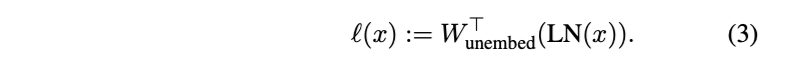

---


### Applicazione dei logit-lens per interpretare un feature

Lo stesso approccio può essere applicato per proiettare, non un generico hidden state, ma un vettore corrispondente ad una particolare feature.


Il codice gestisce due casi:

- **Caso senza SAE**  
  La feature corrisponde a un neurone nel MLP.  
  - Si prende la **riga di `W_out`** corrispondente, che rappresenta la direzione nel residuo attivata da quel neurone.  
  - Si applica `ln_final` e poi `unembed`, ottenendo i logits.

- **Caso con SAE**  
  La feature corrisponde a un **latente del SAE**.  
  - Si prende la colonna `i` della matrice di decoding `W_dec`, che rappresenta il vettore nel residuo ricostruito da quella feature.  
  - Si applica `ln_final` e poi `unembed`, ottenendo i logits.

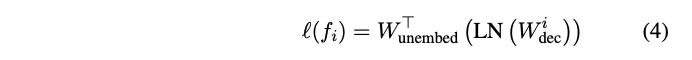


Da questi logits si estraggono:
  - i token più **promossi** (`top_tokens`),
  - i token più **soppressi** (`bottom_tokens`),

Questi token vengono poi passati a un modello explainer per generare una **descrizione interpretabile della feature**, catturandone l’impatto sulle probabilità dei token del modello.  


In [ ]:
VOCAB_PROJ_SYS_PROMPT = "You will be given a list of tokens related to a specific vector. These tokens represent a combination of embeddings that reconstruct the vector. Your task is to infer the most likely meaning or function of the vector based on these tokens. The list may include noise, such as unrelated terms, symbols, or programming jargon. Ignore whether the words are in multiple different languages, and do not mention it in your response. Focus on identifying a cohesive theme or concept shared by the most relevant tokens. Provide a specific sentence summarizing the meaning or function of the vector. Answer only with the summary. Avoid generic or overly broad answers, and disregard any noise in the list.\nVector 1\n    Tokens: ['contentLoaded', '▁hObject', ':✨', '▁AssemblyCulture', 'ContentAsync', '▁ivelany', '▁nahilalakip', 'IUrlHelper', '▁تضيفلها', '▁ErrIntOverflow'] ['▁could', 'could', '▁Could', 'Could', '▁COULD', '▁podría', '▁könnte', '▁podrían', '▁poderia', '▁könnten']\nExplanation of vector 1 behavior: this vector is related to the word could.\nVector 2\n    Tokens: ['▁CreateTagHelper', '▁ldc', 'PropertyChanging', '▁jsPsych', 'ulement', '▁IBOutlet', '▁wireType', '▁initComponents', '▁متعلقه', 'Бахар'] ['▁مشين', '▁charity', '▁donation', '▁charitable', '▁volont', '▁donations', 'iNdEx', 'Parcelize', 'DatabaseError', 'BufferException']\nExplanation of vector 2 behavior: this vector is related to charity and donations.\nVector 3\n    Tokens: ['▁tomorrow', '▁tonight', '▁yesterday', '▁today', 'yesterday', 'tomorrow', '▁demain', '▁Tomorrow', 'Tomorrow', '▁Yesterday'] ['▁Wex', 'ကိုးကား', 'Ārējās', 'piecze', ')$/,', '▁außer', '[]=$', 'cendental', 'ɜ', 'aderie']\nExplanation of vector 3 behavior: this vector is related to specific dates, like tomorrow, tonight and yesterday.\n\n"
VOCAB_PROJ_USER_PROMPT = "Vector 4\n    Tokens: {0}\nExplanation of vector 4 behavior: this vector is related to"

In [ ]:
"""
Esistono alcune varianti per la proiezione dei dati:
a)  utilizzare la matrice di encoding del SAE, al posto della matrice di decoding (encode=True)
b)  utilizzare la matrice di embedding al posto della matrice di unembedding (embed=False)

La combinazione che si mostra avere le performance miglior è quella decoding-unembedding (encode= False, embed=False)
"""

def get_projection_data(m: Model, f: Feature, sae_w=None, encode=False, embed=False, k=50):
    # project properly and get logits
    if sae_w is None:
        logits = m.m.unembed(m.m.ln_final(m.m.blocks[f.layer].mlp.W_out[f.feature]))
    else:
        feature_vector = sae_w[:, f.feature] if encode else sae_w[f.feature]
        logits = (feature_vector @ m.m.embed.W_E.T) if embed else m.m.unembed(m.m.ln_final(feature_vector))
        
    topk = logits.topk(k)
    bottomk = logits.topk(k, largest=False) # k token più soppressi
    abs_topk = logits.abs().topk(k * 2) # k*2 token con variazioni assolute più forti
    top_tokens = m.m.to_str_tokens(topk.indices)
    bottom_tokens = m.m.to_str_tokens(bottomk.indices)
    top_abs_tokens = m.m.to_str_tokens(abs_topk.indices)
    return (logits, topk, bottomk, abs_topk), (top_tokens, bottom_tokens, top_abs_tokens)

def get_dec_unembed(m: Model, f: Feature, sae=None):
    # sometimes these types don't match (e.g. llama's sae_w_dec is 'torch.bfloat16' while the model is 'torch.float32')
    sae_w_dec = None
    if sae is not None:
        sae_w_dec = sae.W_dec
        if sae.W_dec.dtype != m.m.W_U.dtype:
            sae_w_dec = sae.W_dec.to(m.m.W_U.dtype)
    
    # the tokens we actually use - 'value' vectors of SAEs projected using the unembedding matrix #
    _, tokens = get_projection_data(m, f, sae_w_dec)
    (dec_top_tokens, dec_bottom_tokens, dec_top_abs_tokens) = tokens
    
    # take the dec unembed data
    return (dec_top_tokens, dec_bottom_tokens)

In [ ]:
def get_VocabProj_explanation(f: Feature):
    top_tokens, bottom_tokens = get_dec_unembed(m, f, sae=sae)
    vocab_proj_user_prompt = VOCAB_PROJ_USER_PROMPT.format(top_tokens + bottom_tokens)

    vocab_proj_exp = get_description(VOCAB_PROJ_SYS_PROMPT, vocab_proj_user_prompt)
    return vocab_proj_exp

## 3 - TokenChange (TC)

Il metodo **Token Change** cerca di spiegare una feature sulla base di quei **token la cui probabilità di generazione cambia maggiormente quando si amplifica l’attivazione di quella specifica feature**.


1. **Campionamento dei prompt:** si selezionano casualmente `k` prompt da un dataset (es. *The Pile*).  
2. **Calcolo logits di riferimento:** si esegue il modello senza interventi per raccogliere i logits puliti.  I logit vengono raccolti per ogni prompt e per ogni token position. 
4. **Intervento causale:**  
   - Si forza la feature `f` ad un determinato valore e si generano nuovamente i logits.
   - Nel caso in cui la feature in questione sia un latente del SAE, avviene il processo di steering con SAE per come descritto di seguito.
5. **Differenza media:** si calcola la variazione media (sulle diverse token position dei diversi prompt), dei logits steered rispetto ai logit non steered.      
6. **Descrizione della feature:**  - Si selezionano i token con le più alte variazioni di probabilità. La lista dei token viene passata a un modello “explainer”, che restituisce una frase riassuntiva sul significato o la funzione della feature.

Tipicamente si fa clamping della feature sia ad un valore positivo che ad un valore negativo, in maniera tale da indiduare:
- i token con maggiore incremento di logit quando la feature viene amplificata
- i token con maggiore diminuzione di logit quando la feature viene soppressa.


A differenza di **VocabProj** (che è un metodo puramente correlativo), **Token Change** rappresenta un approccio causale, poiché interviene direttamente nell’attivazione della feature per osservare come questo influenza la generazione del modello.


## Feature Steering with Sparse SAE

Il **feature steering** è una tecnica che permette di modificare il comportamento di un modello
manipolando direttamente le attivazioni di una singola **feature** identificata da un SAE
(*Sparse Autoencoder*).

### Procedura

1. **Decomposizione delle attivazioni**
   - Si prende il vettore di attivazioni del modello `x` e lo si scompone in:
     - **SAE(x)** → ricostruzione prodotta dal SAE.
     - **error(x)** → errore di ricostruzione, cioè `x - SAE(x)`.

2. **Modifica di una feature**
   - Si calcola la rappresentazione sparsa `z = E(x)`.
   - Si **clampa** la feature di interesse `z_i` a un valore scelto `c`,
   - Si ricostruisce un nuovo vettore di attivazioni: `x'`
     
     
   - Opzionalmente si aggiunge l’errore di ricostruzione `l = x - x'`
     per preservare meglio l’informazione originale
     

3. **Propagazione in avanti**
   - Si usa il vettore di attivazione così ottenuto come input per i layer successivi del modello,
     osservando come cambia l’output.





In [ ]:
TOKEN_CHANGE_SYS_PROMPT = "You will be given a list of tokens related to a feature in an LLM. These tokens are the ones whose probabilities changed most when amplifying the feature. Your task is to infer the most likely meaning or function of the feature based on these tokens. The list may include noise, such as unrelated terms, symbols, or programming jargon. Provide a specific sentence summarizing the meaning or function of the feature. Answer only with the summary. Avoid generic or overly broad answers."

Discussione parametro "fwd_hooks" del metodo "run_with_hooks_with_saes".
Riceve coppie "nome hook point"/hook_function. Il nome dell'hookpoint è legato al nome del layer del modello su cui è stato addestrato il sae. Nel notebook originale veniva estratto da "sae.cfg.hook_name", tuttavia sae.cfg nel nostro caso non ha un campo "hook_name".
Il dizionario di configurazione di un sae ha dei campi predefiniti che dipendono dall' "architecture" con cui si sceglie di ricostruire il sae. Nel nostro caso l'architecture è "standard", ma questa non contempla il campo "hook_name" nel dizionario di configurazione, sebbene quello estratto da huggingface, che lo usiamo per costruire il sae, lo abbia.
Per questo motivo il nome dell'hookpoint viene estratto dal "cfg_dict" di partenza scaricato da huggingface.

In [ ]:
def set_feature_act_hook(act, hook, feature, value):
    act[:,:,feature] = value

def get_intervention_tokens(model: HookedSAETransformer, pile, f: Feature, value=200, sae=None):

    # print(f"Memoria GPU iniziale: {torch.cuda.memory_allocated()/1e9:.2f}GB")

    prompts = pile[torch.randint(0, len(pile), (32,))].to('cuda:0') 

    clean_logits = model.run_with_saes(prompts, saes=[sae])
    
    pos_inter_logits = model.run_with_hooks_with_saes(prompts, saes=[sae], fwd_hooks=[(f"{sae.cfg.metadata.hook_name}.hook_sae_acts_post", 
                                                                                   functools.partial(set_feature_act_hook, feature=f.feature, value=value))])
    neg_inter_logits = model.run_with_hooks_with_saes(prompts, saes=[sae], fwd_hooks=[(f"{sae.cfg.metadata.hook_name}.hook_sae_acts_post", 
                                                                                   functools.partial(set_feature_act_hook, feature=f.feature, value=-value))])

    # print(f"Memoria GPU Step 1: {torch.cuda.memory_allocated()/1e9:.2f}GB")
    
    del prompts
    torch.cuda.empty_cache()

    # print(f"Memoria GPU Step 2: {torch.cuda.memory_allocated()/1e9:.2f}GB")
    
    # Calcolo la differenza media nei logits rispetto al modello "pulito"
    pos_diff_logits = (pos_inter_logits - clean_logits).mean(dim=0).mean(dim=0)
    neg_diff_logits = (neg_inter_logits - clean_logits).mean(dim=0).mean(dim=0)

    del clean_logits, pos_inter_logits, neg_inter_logits
    torch.cuda.empty_cache()

    # print(f"Memoria GPU Step 3: {torch.cuda.memory_allocated()/1e9:.2f}GB")

    # token più sensibili positivamente con setting del valore positivo e negativo rispettivamente
    pos_toks = model.to_str_tokens(pos_diff_logits.topk(10).indices) + model.to_str_tokens(neg_diff_logits.topk(10, largest=False).indices)

    # token più sensibili negativamente con setting del valore positivo e negativo rispettivamente
    neg_toks = model.to_str_tokens(pos_diff_logits.topk(10, largest=False).indices) + model.to_str_tokens(neg_diff_logits.topk(10).indices)

    del pos_diff_logits, neg_diff_logits
    torch.cuda.empty_cache()

    # print(f"Memoria GPU Step finale: {torch.cuda.memory_allocated()/1e9:.2f}GB")
    
    return pos_toks + neg_toks


In [ ]:
pile = m.get_pile_dataset()

In [ ]:
def get_TokenChange_explanation(f: Feature):
    tokens = get_intervention_tokens(m.m, pile, f, value=10, sae=sae)
    
    token_change_user_prompt = str(list(set(tokens)))
    token_change_exp = get_description(TOKEN_CHANGE_SYS_PROMPT, token_change_user_prompt)
    
    del tokens, token_change_user_prompt
    torch.cuda.empty_cache()

    return token_change_exp

# Score

## 5 - Input score

Questo metodo valuta **la qualità della spiegazione di una feature**, sulla base degli **input che attivano la feature stessa**.  
Data una feature f, si fornisce ad un LLM ausiliario la sua spiegazione, gli si chiede di generare due insiemi di k esempi:
- **attivanti** (che dovrebbero attivare la feature),
- **neutri** (che non dovrebbero attivarla).

Ogni esempio viene passato attraverso il modello da spiegare per ottenere l’attivazione della feature.
L'attivazione di una feature per un esempio, viene calcolata come il massimo dell’attivazione su tutte le token-position. 

Il test ha esito positivo se l'attivazione media sui k esempi attivanti, è maggiore dell'attivazione media sui k esempi non attivanti. 



In [ ]:
#prompt
GEN_LISTS_PROMPT = "I'm going to give you explanations and interpretations of features from LLMs. You must take in each expalantion, and generate 5 sentences for which you think the feature will have a high activation, and 5 for which they'll have a low activation. For the high activation, make sure to choose ones that will cause a high activation with high confidence - you don't have to include all groups, just make examples that you're confident will have high activation. Make the sentences both include the words from the explanation, and represent the concept. Try to use specific examples, and make them literal interpretations of the explanation, without trying to generalize. Low activation sentences should have nothing to do with the interpretation - i.e. they should by orthogonal and completely unrelated. Please output the response in json format with a 'positive' key and a 'negative' key. Output only the json and no other explanation. Make sure the json is formatted correctly - do not include any '`' backtick characters characters, i.e. do not format as code, just return the json text. The explanations should be five and five overall, not per line.\n\n{explanation}\n"

FIX_JSON_PROMPT = """Please fix this json that is not formatted correctly. Write only the fixed json. 
DO NOT write anything but the json. No comments. Only the json itself.\n\n{json}\n"""

In [ ]:
def get_lists(explanation):
    """
    Generates 5 positive and negative activating examples based on our explanation
    """
    return explainer([{"role": "user", "content": GEN_LISTS_PROMPT.format(explanation=explanation)}])
    

#parsing dell'output generato dal modello
def get_pos_neg(lists):
    try:
        json_content = lists.strip().strip("json").strip('`').removeprefix('json\n').removesuffix('\n').strip().strip("json").strip("`").strip('`').removeprefix('json\n').removesuffix('\n')
        j = json.loads(json_content)
        return j["positive"], j["negative"]
    except:
        pass

    for top in range(3):
        for bottom in range(2):
            bottom = None if bottom == 0 else -bottom
            new_lists = lists.splitlines()[top:bottom]

            try:
                j = json.loads(new_lists)
                return j["positive"], j["negative"]
            except:
                pass

    lists = explainer([{"role": "user", "content": FIX_JSON_PROMPT.format(json=lists)}])
    try:
        json_content = lists.strip().strip("json").strip('`').removeprefix('json\n').removesuffix('\n').strip().strip("json").strip("`").strip('`').removeprefix('json\n').removesuffix('\n')
        j = json.loads(json_content)
        return j["positive"], j["negative"]
    except:
        logger.error(lists)
        raise

#calcolo delle attivazioni
def get_pos_neg_acts(model: HookedSAETransformer, pos, neg, f: Feature, pre_relu=False, sae=None):

    pos_cache = model.run_with_cache_with_saes(pos, saes=[sae], return_type=None)[1]
    neg_cache = model.run_with_cache_with_saes(neg, saes=[sae], return_type=None)[1]
    
    relu = "pre" if pre_relu else "post"

    # we take the maximal activation of the feature across all sentences across all tokens
    # we prefer that because we can generate multiple exps per feature and then take the best activations across all exps
    if sae is None:  # transluce
        block = f"blocks.{f.layer}.mlp.hook_post"
    else:
        block = f"{sae.cfg.metadata.hook_name}.hook_sae_acts_{relu}"
        
    pos_act_max_all = pos_cache[block][:, :, f.feature].max().item()   #massimo assoluto sui positivi
    neg_act_max_all = neg_cache[block][:, :, f.feature].max().item()   #massimo assoluto sui negativi
    pos_act_max_toks = pos_cache[block][:, :, f.feature].max(dim=-1).values.mean().item()     #attivazione media sui positivi
    neg_act_max_toks = neg_cache[block][:, :, f.feature].max(dim=-1).values.mean().item()     #attivazione media sui negativi

    return pos_act_max_all, neg_act_max_all, pos_act_max_toks, neg_act_max_toks

In [ ]:
@dataclass
class InputScore:
    pos_act_all: float
    neg_act_all: float
    pos_act_toks: float
    neg_act_toks: float
    pos_list: float
    neg_list: float
    
    def success(self) -> bool:
        # the input metric final test for success
        return self.pos_act_toks > self.neg_act_toks
    
    @classmethod
    def from_row(cls, row):
        return cls(**vars(row))
    

def get_input_score(description: str, m: Model, f: Feature, sae=None, verbose=False) -> InputScore:
    lists = get_lists(description)   # generare le frasi di test   
    # print (lists)
    pos_list, neg_list = get_pos_neg(lists)   # estrarre le frasi di test
    if verbose:
        print ("====Calcolo Input Success====")
        print("=====Frasi positive=====")
        print(pos_list)
        print("=====Frasi negative=====")
        print(neg_list)
    pos_act_all, neg_act_all, pos_act_toks, neg_act_toks = get_pos_neg_acts(m.m, pos_list, neg_list, f, sae=sae)
    if verbose:
        print("attivazione massima frasi postive: ", pos_act_all)
        print("attivazione massima frasi negative:" , neg_act_all)
        
        print("attivazione media frasi postive: ", pos_act_toks)
        print("attivazione media frasi negative:" , neg_act_toks)
    return InputScore(pos_act_all, neg_act_all, pos_act_toks, neg_act_toks, pos_list, neg_list)

## 6 - Output score (steering success)

Questo metodo valuta quanto la **spiegazione di una feature rifletta l’influenza della feature sugli output** del modello. 

Si generano tre set di testi a partire da prompt neutri:  
- il primo set di testi viene generato, **amplificando la feature in esame**,  
- altri due set di testi vengono generati, amplificando due feature campionate in maniera random.

Amplificare una feature, significa imporre un'elevata attivazione per quella feature. Il valore di attivazione viene calcolato in modo tale da **garantire un determinato valore di KL-divergence** tra i logit steered e non-steered.


Fissato un determinato valore di KL-divergence (ad esempio 0.1), si fa una ricerca binaria in un intervallo tra 1 a 1000, per individuare l'attivazione per quella feature che determina quel valore di KL-divergence.

I tre set di testi vengono passati ad un **LLM giudice**, che ha il compito di identificare quale set è stato più verosimilmente generato per amplificazione della feature in esame, sulla base della spiegazione fornita.

Il test ha successo se l'LLM giudice individua il corretto set di token.


In [ ]:
NUM_OF_DISTS=2 # numero di distrattori nell’output score
KL_DIV_VALUES = [0.1, 0.15]

In [ ]:
OUTPUT_METRIC_GENERATION_PROMPTS = ["The explanation is simple:", "I think", "We"]

OUTPUT_METRIC_SYS_PROMPT = """You are analyzing the behavior of a specific neuron in a language model. You will receive:

1. A hypothesized explanation for what concept the neuron represents (e.g., specific tokens, themes, or ideas).
2. Three sets of completions, one generated by amplifying the activation of the neuron in question, and one of a random neuron across the same prompts.

Your goal is to identify which set of completions is more likely the result of amplifying the neuron in question. To do this:
- Look for completions where the **literal words** or the **ideas/themes** described in the explanation occur more frequently or with greater emphasis.
- Remember that amplification may highlight specific words or their broader contextual meanings, meaning that a lot of the times they might be very noisy, but contain keywords that appear in the explanation.
- Your answer should be based on the **content** of the completions, not the quality of the language model's output.
- Your reasoning should be sound, don't make overly elaborate and far-fetched connections.

The first line in your response should be a brief explanation of your choice - what made you choose that set of completions.
The second line must be only the set number you think matches the description (i.e., 1, 2 or 3) and no other text. You must pick one of the three sets.
"""

STEERING_AMP_PROMPT_TEMPLATE = """<{amplification}> {completions}\n"""

STEERING_FULL_PROMPT_TEMPLATE = """Explanation: {explanation}

# Set 1
{amplifications1}

# Set 2
{amplifications2}

# Set 3
{amplifications3}
"""

In [ ]:
def set_feature_act_kl_hook(act, hook, feature: int, value):
    """
    callback che viene richiamata quando il modello calcola le attivazioni
    
    - act è il tensore della attivazioni, tipicamente (batch_size, seq_len, d_model)
    - feature è l'indice della feature
    - value è il valore di attivazione della feature


    """
    act[:,:,feature] = value

def kl_div(p, q, eps=1e-10):
    """
    Get the KL Divergence between p and q
    """
    p = p.clamp(min=eps)  #fa clampimg di un epsilon per evitare di fare log(0)
    q = q.clamp(min=eps)  #fa clamping di un epsilon per evitare di fare log(0)
    return torch.sum(p * (torch.log(p) - torch.log(q)), dim=-1)
    #in generale p e q sono dei tensori di forma (batch_size, seq_len, vocab_size), quindi bisogna fare le operazioni sull'ultima dimensione

#restituisce la divergenza di kullback leibler tra le attivazioni pulite e le attivazioni dopo il clamping della feature. 
def get_kl_div(model: Model, prompts, f: Feature, value, sae=None):
    """
    Get KL Divergence between clean and hooked activations when clamping the feature to value, 
    averaged over all of the prompts
    """
    #tokenizzazione
    toks = model.m.to_tokens(prompts)

    clean_probs = model.m.run_with_saes(toks, saes=[sae])
    hooked_probs = model.m.run_with_hooks_with_saes(toks, saes=[sae], fwd_hooks=[(f"{sae.cfg.metadata.hook_name}.hook_sae_acts_post", 
                                                                              functools.partial(set_feature_act_kl_hook, feature=f.feature, value=value))]).softmax(dim=-1)
    clean_probs = clean_probs.softmax(dim=-1)

    # Remove logits which are padding tokens
    clean_probs[toks == 0] = 0
    hooked_probs[toks == 0] = 0

    # return hooked_probs, clean_probs
    kl = kl_div(clean_probs, hooked_probs)
    means = []
    for row in kl:
        means.append(row[row != 0].mean().item())

    return np.mean(means)
    #Alla fine si restituisce la media delle medie delle divergenze di kullback-leibler


#trova il valore di attivazione per una feature ad una definita soglia di divergenza di kullback-leibler.
#fa una ricerca binaria all'interno di un certo intervallo (0, 1000)
def get_activation_for_kl(model: Model, prompts, f: Feature, target_kl, high_thresh=0.1, neg=False, verbose=False, sae=None):
    """
    Find the activation value we need for the desired target KL Divergence value
    """
    # Do binary search between 0 and 1000
    low, high = (-1000, -1) if neg else (1, 1000)
    kl = -1
    mid = 0
    while (low+1 < high) and (kl < target_kl or kl > target_kl + high_thresh):
        mid = (low + high) // 2
        kl = get_kl_div(model, prompts, f, mid, sae=sae)

        if (neg and kl < target_kl) or (not neg and kl > target_kl):
            high = mid
        else:
            low = mid

        if verbose:
            print(f"Low: {low}, High: {high}, Mid: {mid}, KL: {kl}, Target KL: {target_kl}")

    return mid

In [ ]:
def get_completions_for_kl_val(model: Model, prompts, f: Feature, kl, neg=False, sae=None):
    act = get_activation_for_kl(model, prompts, f, kl, neg=neg, sae=sae)
    positive = hooked_gen(model.m.to_tokens(prompts), model, f, n=25, value=act, temperature=0.75, sae=sae)
    return [x.replace("\n", "\\n").replace("\r", "\\r") for x in positive]

@dataclass
class OutputScore:
    correct_choice: int
    chosen_index: int

    def success(self):
        if self.chosen_index==4:
            return "failed test"
        # the output metric final test for success
        return self.correct_choice == self.chosen_index
    
def to_int(s):
    try:
        return int(re.search(r'\d+', s).group())
    except: 
        return 4

#Per ogni valore di divergenza di kullback-leibler fissato, per ognuno dei tre prompt neutrali genera gli output, facendo steering di due featur casuali.
def get_random_amps(m: Model, f: Feature, sae=sae):
    random_amps = ["" for _ in range(NUM_OF_DISTS)]
    for i in KL_DIV_VALUES:
        for x in range(NUM_OF_DISTS):
            ampy = random_amps[x]
            
            random_feature = random.sample(range(sae.cfg.d_sae), 1)[0]
    
            random_f = Feature(m.model_id, random_feature, f.layer, f.type)
            rand_pos = get_completions_for_kl_val(m, OUTPUT_METRIC_GENERATION_PROMPTS, random_f, i, sae=sae)
            ampy += f"\n<{'+' if i >= 0 else ''}{i}>" + f"\n<{'+' if i >= 0 else ''}{i}>".join([f"'{OUTPUT_METRIC_GENERATION_PROMPTS[x]}': '{rand_pos[x]}'" for x in range(len(rand_pos))])
            random_amps[x] = ampy

    return random_amps


def get_output_score(description: str, m: Model, f: Feature, sae=None, verbose=False) -> OutputScore:
    
    amps = ""
    for i in KL_DIV_VALUES:
        pos = get_completions_for_kl_val(m, OUTPUT_METRIC_GENERATION_PROMPTS, f, abs(i), neg=False if i>=0 else True, sae=sae)
        amps += f"\n<{'+' if i >= 0 else ''}{i}>" + f"\n<{'+' if i >= 0 else ''}{i}>".join([f"'{OUTPUT_METRIC_GENERATION_PROMPTS[x]}': '{pos[x]}'" for x in range(len(pos))])



    random_amps = get_random_amps(m, f)
    random_amps = random_amps.copy()
    random_amps.append(amps)

    random_indices = random.sample(range(3), 3)
    ordered_amps = [random_amps[i] for i in random_indices]
    correct_choice = random_indices.index(2) + 1
    
    prompt = STEERING_FULL_PROMPT_TEMPLATE.format(explanation=description, amplifications1=ordered_amps[0], amplifications2=ordered_amps[1], amplifications3=ordered_amps[2])
    
    if (verbose):
        print ("====Calcolo steering success====")
        print("PROMPT EXPLAINER: ", prompt)
    
    response = explainer([
        {"role": "user", "content": OUTPUT_METRIC_SYS_PROMPT + "\n\n" + prompt}
    ], weak=True)

    

    chosen_index = to_int(response.splitlines()[-1])
    

    if (verbose):
        print ("Chosen index: ", chosen_index)
        print ("Correct choice: ", correct_choice)
    return OutputScore(correct_choice, chosen_index)    

In [ ]:
def gen_hook(clean_act, hook,  feature: int, value, sae=None):
    """
    Manually steers the value inside an SAE activation using the basic activation
    :param clean_act: the basic activation before the SAE
    """
    if sae is None:  # transluce
        clean_act[:,:,feature] = value
        return clean_act
    
    encoded_act = sae.encode(clean_act)
    dirty_act = sae.decode(encoded_act)
    error_term = clean_act - dirty_act

    encoded_act[:,:,feature] = value
    hooked_act = sae.decode(encoded_act) + error_term

    return hooked_act
    
#generazione del modello di n tokens con lo steering effettuato    
def hooked_gen(prompt, model: Model, f: Feature, n=25, value=10, do_sample= True, verbose=False, temperature=1, sae=None):
    """
    :param prompt: the prompt for which the model will generate text
    :param value: the value to amplify the feature with
    """
    model.m.reset_hooks()
    block = f"blocks.{f.layer}.mlp.hook_pre" if sae is None else cfg_dict['metadata']['hook_name']
    model.m.add_hook(block, functools.partial(gen_hook, feature=f.feature, value=value, sae=sae))
    output = model.m.generate(prompt, max_new_tokens=n, do_sample=do_sample, verbose=verbose, temperature=temperature)
    model.m.reset_hooks()

    return [x[len(model.m.to_string(prompt[i])):] for i, x in enumerate(model.m.to_string(output))]

# Features analisys

In [ ]:
def explain_latents(f: Feature):
    explanation_MaxAct, surprisal_score = get_MaxAct_explanation(f)
    explanation_VocabProj = get_VocabProj_explanation(f)
    explanation_TokenChange = get_TokenChange_explanation(f)
    return explanation_MaxAct, surprisal_score, explanation_VocabProj, explanation_TokenChange

In [ ]:
def generate_latents(sample_dim, seed=seed):
    random.seed(seed)  # Imposta il seed per la riproducibilità
    latents_to_explain = []

    def condition(num):
        f = Feature(model_name, num, num_layer , type_layer, [], size="131k") 
        raw_dir = f"/kaggle/working/progetto_nlp_2/results/test-run/latents/{hookpoint_dir}"
        hookpoints, latents = inizialize_environment(f.feature-1, f.feature+2, raw_dir)
        buffers = create_buffer(hookpoints, latents, raw_dir)
        tokens = upload_dataset()
        records = extract_data(buffers, tokens)
        convert_feature(f, records)
        return len(f.activations) > 1

    while len(latents_to_explain) < sample_dim:
        num = random.randint(1, cfg_dict["d_sae"])  #controllare
        if condition(num):
            latents_to_explain.append(num)

    return latents_to_explain

In [ ]:
def calcolate_scores(techniques, explanations, f: Feature, verbose=False):
    result = {}
    assert len(explanations) == 3
    for idx, exp in enumerate(explanations):
        print("Explanation from ",techniques[idx], " : ", exp)
        vp_input_score = get_input_score(exp, m, f, sae=sae, verbose=verbose)
        vp_out_score = get_output_score(exp, m, f, sae=sae, verbose=verbose)
        result[techniques[idx]] = [vp_input_score.success(), vp_out_score.success()]
        print(" \n Success for InputScore: ", vp_input_score.success(), " \n Success for OutputScore: ", vp_out_score.success())
    return result

In [ ]:
range_latents = generate_latents(sample_dim)
all_results = []

for latent in range_latents:
    f = Feature(model_name, latent, num_layer, type_layer, [], size="16k") 
    print(f"=== Explaining latent {latent} ===")

    explanations = [exp for exp in explain_latents(f)]
    surprisal_score = explanations[1]
    explanations = explanations[:1] + explanations[2:]
    scores = calcolate_scores(["MaxAct", "VocabProj", "TokenChange"], explanations, f, True)

    latent_result = {"latent": latent, "surprisal_score": surprisal_score, "techniques": []}

    for idx, technique_name in enumerate(scores):
        values = scores[technique_name]
        technique_data = {
            "technique": technique_name,
            "explanation": explanations[idx],
            "input score": values[0],
            "output score": values[1]
        }
        latent_result["techniques"].append(technique_data)

    all_results.append(latent_result)
    print("==================================")
    with open('latent_explanations.json', 'w') as f:
        json.dump(all_results, f, indent=2)

with open('latent_explanations.json', 'w') as f:
    json.dump(all_results, f, indent=2)
print("Risultati salvati in latent_explanations.json")